![](data.png)

In [213]:
import pandas as pd
import statistics as st
import numpy as np
#from pandas_profiling import ProfileReport#авто анализ
#import sweetviz as sv#авто анализ
#import dtale #авто анализ
#import matplotlib.pyplot as plt # библиотека визуализации
#from scipy import stats # библиотека для расчетов
#from sklearn.metrics import matthews_corrcoef#корреляция мэтьюса
#import seaborn as sns #Визуализация


import warnings
warnings.filterwarnings('ignore')

In [214]:
data = pd.read_csv('wine_cleared.csv')
data.head(5)

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


Создадим новый признак price_round, означающий округлённую до целого числа цену за бутылку вина:

In [215]:
# для удобства сразу преобразуем признак в int
data['price_round'] = data['price'].round().astype(int)

                                     РАЗБОР ТЕКСТА

Текстовые признаки могут содержать в себе большое количество информации. Например, если бы наша модель умела распознавать текст, то из описания вина мы бы могли понять, какими словами сомелье чаще характеризуют качественное вино. Вы можете воспользоваться методами извлечения слов из текста, чтобы получить новые признаки.

В названии вина вы можете заметить указание года произведения вина. Чтобы узнать, влияет ли год на рейтинг вина, вам необходимо выделить год в отдельный признак.

Для того, чтобы извлечь из строки число, обозначающее год, необходимо воспользоваться регулярными выражениями.

Регулярные выражения (regexp, или regex) — это механизм для поиска и замены текста. Это шаблоны, которые используются для поиска соответствующей части текста.

Например, с помощью такого регулярного выражения [^@ \t\r\n]+@[^@ \t\r\n]+\.[^@ \t\r\n]+ можно найти любой email в тексте.

Синтаксис регулярных выражений необычен и содержит различные символы, знаки препинания, математических операций и так далее. Подробнее ознакомиться с синтаксисом регулярных выражений поможет статья Python RegEx: практическое применение регулярок.

Реализация такого механизма существует в pandas в работе со строками. Для того чтобы найти все числа в каждом значении серии, воспользуемся методом str.findall(). Метод возвращает все совпадения с заданным шаблоном в серии pandas. 

✍️ Выполните код для нахождения года вина при помощи регулярного выражения:

In [216]:
regex = '\d{4}' # регулярное выражение для нахождения чисел
data['year'] = data['title'].str.findall(regex).str.get(0)
#data['year'] = pd.to_datetime(data['year'], format='%Y', errors='coerce')#изменяем тип строки на дату

                               РАЗБОР КАТЕГОРИЙ

В наборе данных винных обзоров самая популярная страна-производитель вина — США. Возможно, это не случайность, и факт производства в США влияет на рейтинг вина. Выделим этот факт.

Вы можете создать новый бинарный признак is_usa и присвоить ему 1 в случае, если вино произведено в США, иначе — 0.

In [217]:
data['is_usa'] = data['country'].apply(lambda x: 1 if x == 'US' else 0)

In [218]:
data['is_france'] = data['country'].apply(lambda x: 1 if x == 'France' else 0)
data['is_france'].sum()

22093

In [219]:
data['is_italy'] = data['country'].apply(lambda x: 1 if x == 'Italy' else 0)
data['is_italy'].sum()

19540

In [220]:
data['year']= data['year'].astype (float)
data['old_wine'] = data['year'].apply(lambda x: 1 if x < 2010 else 0)
data['old_wine'].sum()

39781

In [221]:
regex = '\((.*?)\)' # регулярное выражение для нахождения текста в скобках
data['locality'] = data['title'].str.findall(regex).str.get(0)

                                 РАБОТА С ФАЙЛАМИ

Часто маленькие страны с небольшим количеством населения имеют узкую специализацию. Например, в производстве вина особенно успешны Франция, Италия, Испания, Новая Зеландия. Чтобы проверить, влияет ли на качество вина населённость, выясним информацию о населении страны, в котором была произведена бутылка вина. 

In [222]:
country_population = pd.read_csv('country_population.csv', sep=';')

country_population

,country,population
0,China,"1,411,778,724"
1,India,"1,386,584,581"
2,US,"333,022,386"
3,Indonesia,"271,350,000"
4,Pakistan,"225,200,000"
...,...,...
236,Niue,"1,549"
237,Tokelau,"1,501"
238,Vatican City,825
239,Cocos Islands,573


Каково население Италии согласно датасету country_population? Ответ вводите без пробелов и запятых.

In [223]:
country_population[country_population['country']=='Italy']

,country,population
24,Italy,"59,097,904"


Далее сопоставим значения из датасета country_population и страной-производителем вина. На основе значений населения из country_population заполним новый признак country_population.

Используем для этого функцию для объединения датасетов join. Для объединения используем аргумент on='country', указывая столбец, по которому объединяем датафреймы:

In [224]:
data=data.join(country_population.set_index('country'), on='country')
data.head(2)

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery,price_round,year,is_usa,is_france,is_italy,old_wine,locality,population
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia,35,2013.0,0,0,1,0,Etna,"59,097,904"
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos,15,2011.0,0,0,0,0,Douro,"10,347,892"


In [225]:
country_area = pd.read_csv('country_area.csv', sep=';')
country_area['area_country'] = country_area['area']
country_area.drop (columns=country_area.columns [1], axis= 1 , inplace= True )
country_area


,country,area_country
0,Russia,17075400.00
1,Canada,9984670.00
2,China,9596960.00
3,US,9372610.00
4,Brazil,8547000.00
...,...,...
188,San Marino,61.00
189,Tuvalu,26.00
190,Nauru,21.00
191,Monaco,2.00


Создайте новый признак area_country — площадь страны, аналогичный признаку country_population.

Какая площадь страны у вина под названием 'Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))'? Ответ вводите без пробелов, округлите до целых.

In [226]:
data=data.join(country_area.set_index('country'), on='country')
data.head(2)

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,...,winery,price_round,year,is_usa,is_france,is_italy,old_wine,locality,population,area_country
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),...,Nicosia,35,2013.0,0,0,1,0,Etna,"59,097,904",301230.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,Quinta dos Avidagos,15,2011.0,0,0,0,0,Douro,"10,347,892",92391.0


In [227]:
di=data[data['title']=='Gård 2014 Grand Klasse Reserve Lawrence Vineyards Viognier (Columbia Valley (WA))']
print(f'area', di['area_country'])

area 94    9372610.0
Name: area_country, dtype: float64


Работа с форматом «дата-время»

Давайте рассмотрим, из каких признаков состоит срез данных:

client_id — идентификатор клиента в базе;
agent_date — время соединения с агентом;
created_at — время соединения с клиентом (начало разговора);
end_date — время окончания соединения с клиентом (конец разговора).


In [229]:
import pandas as pd 

# инициализируем информацию о звонках
calls_list = [
    [460, '2013-12-17 04:55:39', '2013-12-17 04:55:44', '2013-12-17 04:55:45'],
    [12, '2013-12-16 20:03:20', '2013-12-16 20:03:22', '2013-12-16 20:07:13'],
    [56, '2013-12-16 20:03:20', '2013-12-16 20:03:20', '2013-12-16 20:05:04'],
    [980, '2013-12-16 20:03:20','2013-12-16 20:03:27', '2013-12-16 20:03:29'],
    [396, '2013-12-16 20:08:27', '2013-12-16 20:08:28','2013-12-16 20:12:03'],
    [449, '2013-12-16 20:03:20', '2013-12-16 20:03:25','2013-12-16 20:05:00'],
    [397, '2013-12-16 20:08:25', '2013-12-16 20:08:27', '2013-12-16 20:09:59'],
    [398, '2013-12-16 20:01:23', '2013-12-16 20:01:23', '2013-12-16 20:04:58'],
    [452, '2013-12-16 20:03:20', '2013-12-16 20:03:21','2013-12-16 20:04:55'],
    [440, '2013-12-16 20:03:20', '2013-12-16 20:04:26', '2013-12-16 20:04:32']
]

calls = pd.DataFrame(calls_list, columns = ['client_id',  'agent_date', 'created_at' ,'end_date'])

# преобразовываем признаки в формат datetime для удобной работы

calls['agent_date'] = pd.to_datetime(calls['agent_date'])
calls['created_at'] = pd.to_datetime(calls['created_at'])
calls['end_date'] = pd.to_datetime(calls['end_date'])

calls

,client_id,agent_date,created_at,end_date
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32


Все признаки в наборе данных, за исключением номера клиента, представляют собой дату и время. Давайте создадим несколько признаков из этих данных.

Мы можем посчитать, сколько примерно длилось время разговора клиента и сотрудника компании — длительность разговора. 

Подсчитаем разницу между датой и временем начала разговора с клиентом и датой и временем окончания звонка.

In [230]:
calls['duration'] = (calls['end_date'] - calls['created_at']).dt.seconds
calls

,client_id,agent_date,created_at,end_date,duration
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45,1
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13,231
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04,104
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29,2
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03,215
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00,95
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59,92
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58,215
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55,94
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32,6


Подсчитайте, сколько секунд тратят сотрудники компании на дозвон клиенту. Результат запишите в новый признак time_connection.

В ответ запишите результат выполнения следующего кода: calls['time_connection'].sum().

In [231]:
calls['time_connection'] = (calls['created_at'] - calls['agent_date']).dt.seconds
display(calls)
calls['time_connection'].sum()

,client_id,agent_date,created_at,end_date,duration,time_connection
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45,1,5
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13,231,2
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04,104,0
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29,2,7
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03,215,1
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00,95,5
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59,92,2
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58,215,0
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55,94,1
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32,6,66


89

Создайте новый признак is_connection — факт соединения с клиентом. Признак будет равен 1 в случае, если разговор состоялся и продлился больше 10 секунд, иначе — 0.

В ответ запишите результат выполнения следующего кода: calls['is_connection'].sum().

In [232]:
calls['is_connection'] = calls['duration'].apply(lambda x: 1 if x >= 10 else 0)
display(calls)
calls['is_connection'].sum()

,client_id,agent_date,created_at,end_date,duration,time_connection,is_connection
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45,1,5,0
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13,231,2,1
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04,104,0,1
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29,2,7,0
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03,215,1,1
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00,95,5,1
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59,92,2,1
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58,215,0,1
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55,94,1,1
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32,6,66,0


7

Создайте признак time_diff — разницу в секундах между началом звонка(не разговора) и его окончанием.

В ответ запишите результат выполнения следующего кода: calls['time_diff'].sum().

In [233]:
calls['time_diff'] = (calls['end_date'] - calls['agent_date']).dt.seconds
display(calls)
calls['time_diff'].sum()

,client_id,agent_date,created_at,end_date,duration,time_connection,is_connection,time_diff
0,460,2013-12-17 04:55:39,2013-12-17 04:55:44,2013-12-17 04:55:45,1,5,0,6
1,12,2013-12-16 20:03:20,2013-12-16 20:03:22,2013-12-16 20:07:13,231,2,1,233
2,56,2013-12-16 20:03:20,2013-12-16 20:03:20,2013-12-16 20:05:04,104,0,1,104
3,980,2013-12-16 20:03:20,2013-12-16 20:03:27,2013-12-16 20:03:29,2,7,0,9
4,396,2013-12-16 20:08:27,2013-12-16 20:08:28,2013-12-16 20:12:03,215,1,1,216
5,449,2013-12-16 20:03:20,2013-12-16 20:03:25,2013-12-16 20:05:00,95,5,1,100
6,397,2013-12-16 20:08:25,2013-12-16 20:08:27,2013-12-16 20:09:59,92,2,1,94
7,398,2013-12-16 20:01:23,2013-12-16 20:01:23,2013-12-16 20:04:58,215,0,1,215
8,452,2013-12-16 20:03:20,2013-12-16 20:03:21,2013-12-16 20:04:55,94,1,1,95
9,440,2013-12-16 20:03:20,2013-12-16 20:04:26,2013-12-16 20:04:32,6,66,0,72


1144

Итак, мы получили четыре новых признака для нашего набора данных: duration, time_connection, is_connection, time_diff. После генерации признаков из дат исходные признаки agent_date, created_at, end_date нам больше не нужны — передать на вход модели мы им не сможем, так как большинство моделей машинного обучения умеют работать только с числами, даты и текст ей недоступны, поэтому удалим их:

In [234]:
calls = calls.drop(columns=['agent_date', 'created_at' ,'end_date'], axis=1)

Создайте признак количество дней с момента произведения вина — years_diff для датасета винных обзоров. За дату отсчёта возьмите 12 января 2022 года. В ответ впишите максимальное количество дней с момента произведения вина. Ответ округлите до целого числа.

In [235]:
regex = '\d{4}' # регулярное выражение для нахождения чисел
data['year'] = data['title'].str.findall(regex).str.get(0)
data['year'] = pd.to_datetime(data['year'], format='%Y', errors='coerce')#изменяем тип строки на дату

In [236]:
data['year'] = pd.to_datetime(data['year'])
data['years_diff'] = (pd.to_datetime("2022-01-12") - data['year']).dt.days
data['years_diff'].max()

98627.0

                            порядковое кодирование.   

![](code.png)

In [237]:
import category_encoders as ce

Рассмотрим следующие популярные способы кодирования: 

порядковое кодирование (Ordinal Encoding); 
однократное кодирование (OneHot Encoding); 
бинарное кодирование (Binary Encoding).
Создадим обучающий набор для кодирования порядковых признаков — ассортимент небольшого магазина с одеждой, где size — буквенное обозначение размера одежды, type — тип изделия.

In [238]:
# инициализируем информацию об одежде
clothing_list = [
    ['xxs', 'dress'],
    ['xxs', 'skirt'],
    ['xs', 'dress'],
    ['s', 'skirt'],
    ['m', 'dress'],
    ['l', 'shirt'],
    ['s', 'coat'],
    ['m', 'coat'],
    ['xxl', 'shirt'],
    ['l', 'dress']
]

clothing = pd.DataFrame(clothing_list, columns = ['size',  'type'])
clothing

,size,type
0,xxs,dress
1,xxs,skirt
2,xs,dress
3,s,skirt
4,m,dress
5,l,shirt
6,s,coat
7,m,coat
8,xxl,shirt
9,l,dress


Выполним теперь кодирование порядкового признака size в Python. Порядковое кодирование в библиотеке реализовано в классе OrdinalEncoder. По умолчанию все строковые столбцы будут закодированы.

Метод fit_transform устанавливает соответствия для кодирования и преобразовывает данные в соответствие с ними. Затем используем метод concat() для добавления закодированного признака в датафрейм data.

In [239]:
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(clothing[['size']])
clothing = pd.concat([clothing, data_bin], axis=1)
clothing

,size,type,size
0,xxs,dress,1
1,xxs,skirt,1
2,xs,dress,2
3,s,skirt,3
4,m,dress,4
5,l,shirt,5
6,s,coat,3
7,m,coat,4
8,xxl,shirt,6
9,l,dress,5


Используйте ранее изученные методы кодирования и закодируйте признак year в датасете винных обзоров порядковым кодированием.

In [241]:
wine_cleared=data.copy()
wine_cleared.head(2)


,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,...,price_round,year,is_usa,is_france,is_italy,old_wine,locality,population,area_country,years_diff
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),...,35,2013-01-01,0,0,1,0,Etna,"59,097,904",301230.0,3298.0
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,15,2011-01-01,0,0,0,0,Douro,"10,347,892",92391.0,4029.0


In [242]:
import category_encoders as ce

ord_encoder = ce.OrdinalEncoder(cols=['year'])
year_col = ord_encoder.fit_transform(wine_cleared['year'])
data = pd.concat([wine_cleared, year_col], axis=1)

In [244]:
data.head(5)

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,...,year,is_usa,is_france,is_italy,old_wine,locality,population,area_country,years_diff,year
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),...,2013-01-01,0,0,1,0,Etna,"59,097,904",301230.0,3298.0,1
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,2011-01-01,0,0,0,0,Douro,"10,347,892",92391.0,4029.0,2
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),...,2013-01-01,1,0,0,0,Willamette Valley,"333,022,386",9372610.0,3298.0,1
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,...,2013-01-01,1,0,0,0,Lake Michigan Shore,"333,022,386",9372610.0,3298.0,1
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,2012-01-01,1,0,0,0,Willamette Valley,"333,022,386",9372610.0,3664.0,3


               ОДНОКРАТНОЕ КОДИРОВАНИЕ. ONE-HOT ENCODING
Однократное кодирование (его ещё часто называют «горячим») является автоматизированным кодированием, которое мы делали в юните Создание признаков. Для каждой новой категории создается новый бинарный признак. Значение 1 в этих признаках проставляется там, где значение исходного признака равно этой категории. 

Закодируем признак type в Python. Используем класс OneHotEncoding библиотеки category_encoders. Укажем в cols наименование признака type для кодировки, иначе будут закодированы все строковые столбцы.

In [245]:
import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['type']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(clothing['type'])
clothing = pd.concat([clothing, type_bin], axis=1)

clothing

,size,type,size,type_1,type_2,type_3,type_4
0,xxs,dress,1,1,0,0,0
1,xxs,skirt,1,0,1,0,0
2,xs,dress,2,1,0,0,0
3,s,skirt,3,0,1,0,0
4,m,dress,4,1,0,0,0
5,l,shirt,5,0,0,1,0
6,s,coat,3,0,0,0,1
7,m,coat,4,0,0,0,1
8,xxl,shirt,6,0,0,1,0
9,l,dress,5,1,0,0,0


На самом деле метод однократного кодирования реализован в pandas в функции pd.get_dummies(). Для выполнения кодирования достаточно передать в функцию DataFrame и указать столбцы, для которых должно выполняться кодирование. По умолчанию кодирование выполняется для всех столбцов типа object:

In [255]:
clothing_dummies = pd.get_dummies(clothing, columns=['type'])
clothing_dummies

,size,size,type_coat,type_dress,type_shirt,type_skirt
0,xxs,1,0,1,0,0
1,xxs,1,0,0,0,1
2,xs,2,0,1,0,0
3,s,3,0,0,0,1
4,m,4,0,1,0,0
5,l,5,0,0,1,0
6,s,3,1,0,0,0
7,m,4,1,0,0,0
8,xxl,6,0,0,1,0
9,l,5,0,1,0,0


Новые бинарные признаки также часто называются dummy-признаками или dummy-переменными. 

В нашем наборе данных винных обзоров признак, обозначающий имя сомелье (taster_name), является номинальным. Закодируйте его, используя One-Hot Encoding.

В ответе напишите, сколько признаков добавилось после применения кодирования.

In [ ]:
import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['taster_name']) # указываем столбец для кодирования
taster_name_bin = encoder.fit_transform(data['taster_name'])
data = pd.concat([data, taster_name_bin], axis=1)

Вернёмся к примеру с магазином одежды. Закодируем бинарным способом признак type в Python. Используем класс BinaryEncoder библиотеки category_encoders.

In [256]:
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['type']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(clothing['type'])
clothing = pd.concat([clothing, type_bin], axis=1)

clothing

,size,type,size,type_0,type_1,type_2
0,xxs,dress,1,0,0,1
1,xxs,skirt,1,0,1,0
2,xs,dress,2,0,0,1
3,s,skirt,3,0,1,0
4,m,dress,4,0,0,1
5,l,shirt,5,0,1,1
6,s,coat,3,1,0,0
7,m,coat,4,1,0,0
8,xxl,shirt,6,0,1,1
9,l,dress,5,0,0,1


In [ ]:
#clothing = clothing.drop(columns=['type_0', 'type_1' ,'type_2'], axis=1)


Закодируйте признак country двоичным способом.

Сколько новых признаков образовалось после кодирования признака country?

In [258]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129972 entries, 0 to 129970
Data columns (total 43 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   country                129972 non-null  object        
 1   description            129972 non-null  object        
 2   designation            129972 non-null  object        
 3   points                 129972 non-null  int64         
 4   price                  129972 non-null  float64       
 5   province               129972 non-null  object        
 6   region_1               129972 non-null  object        
 7   taster_name            129972 non-null  object        
 8   taster_twitter_handle  129972 non-null  object        
 9   title                  129972 non-null  object        
 10  variety                129972 non-null  object        
 11  winery                 129972 non-null  object        
 12  price_round            129972 non-null  int6

In [259]:
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['country']) # указываем столбец для кодирования
country_bin = bin_encoder.fit_transform(data['country'])
data = pd.concat([data, country_bin], axis=1)
data.head(5)

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,...,taster_name_17,taster_name_18,taster_name_19,taster_name_20,country_0,country_1,country_2,country_3,country_4,country_5
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),...,0,0,0,0,0,0,0,0,0,1
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,0,0,0,0,0,0,0,0,1,0
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),...,0,0,0,0,0,0,0,0,1,1
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,...,0,0,0,0,0,0,0,0,1,1
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,0,0,0,0,0,0,0,0,1,1


На основе изученного материала определите подходящий способ кодирования признака taster_twitter_handle из датасета винных обзоров и закодируйте его.

В ответе напишите, сколько признаков добавилось после применения кодирования.

In [260]:
bin_encoder = ce.BinaryEncoder(cols=['taster_twitter_handle']) # указываем столбец для кодирования
taster_bin = bin_encoder.fit_transform(data['taster_twitter_handle'])
data = pd.concat([data, taster_bin], axis=1)
data.head(5)

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,...,country_1,country_2,country_3,country_4,country_5,taster_twitter_handle_0,taster_twitter_handle_1,taster_twitter_handle_2,taster_twitter_handle_3,taster_twitter_handle_4
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,35.363389,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),...,0,0,0,0,1,0,0,0,0,1
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.000000,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,0,0,0,1,0,0,0,0,1,0
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,14.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),...,0,0,0,1,1,0,0,0,1,1
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.000000,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,...,0,0,0,1,1,0,0,1,0,0
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.000000,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,0,0,0,1,1,0,0,0,1,1


Определите типы признаков и закодируйте их в соответствии с изученными способами.

In [264]:
list_of_dicts = [
 {'product': 'Product1', 'price': 1200, 'payment_type': 'Mastercard'},
 {'product': 'Product2', 'price': 3600, 'payment_type': 'Visa'},
 {'product': 'Product3', 'price': 7500, 'payment_type': 'Amex'}
]
df = pd.DataFrame(list_of_dicts)
df

,product,price,payment_type
0,Product1,1200,Mastercard
1,Product2,3600,Visa
2,Product3,7500,Amex


In [263]:
#порядковое кодирование
ord_encoder = ce.OrdinalEncoder()
df_bin = ord_encoder.fit_transform(df[['product']])
df = pd.concat([df, df_bin], axis=1)
#бинарное кодирование карты
bin_encoder = ce.BinaryEncoder(cols=['payment_type']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(df['payment_type'])
df = pd.concat([df, type_bin], axis=1)
df

,product,price,payment_type,product,payment_type_0,payment_type_1
0,Product1,1200,Mastercard,1,0,1
1,Product2,3600,Visa,2,1,0
2,Product3,7500,Amex,3,1,1


In [265]:
encoder = ce.OneHotEncoder(cols=['product','payment_type'])
cols = encoder.fit_transform(df[['product','payment_type']])
df = pd.concat([df, cols], axis=1)
df

,product,price,payment_type,product_1,product_2,product_3,payment_type_1,payment_type_2,payment_type_3
0,Product1,1200,Mastercard,1,0,0,1,0,0
1,Product2,3600,Visa,0,1,0,0,1,0
2,Product3,7500,Amex,0,0,1,0,0,1


                                 НОРМАЛИЗАЦИЯ

Нормализация — один из методов преобразования входных признаков, при котором значения признаков приводятся к заданному диапазону, например [0,...,1]. 

Существует несколько способов нормализации: MinMaxScaler, RobustScaler.



In [266]:
import numpy as np 
import pandas as pd

np.random.seed(34)

# для нормализации, стандартизации
from sklearn import preprocessing

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
matplotlib.style.use('ggplot')

# сгенерируем датасет из случайных чисел
df = pd.DataFrame({ 
    # Бета распределение, 5 – значение альфа, 1 – значение бета, 1000 – размер
    'beta': np.random.beta(5, 1, 1000) * 60,
    
    # Экспоненциальное распределение, 10 – "резкость" экспоненты, 1000 – размер
    'exponential': np.random.exponential(10, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 2 – стандартное отклонение, 1000 – количество сэмплов
    'normal_p': np.random.normal(10, 2, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 10 – стандартное отклонение, 1000 – количество сэмплов
    'normal_l': np.random.normal(10, 10, 1000),
})

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(df.columns)

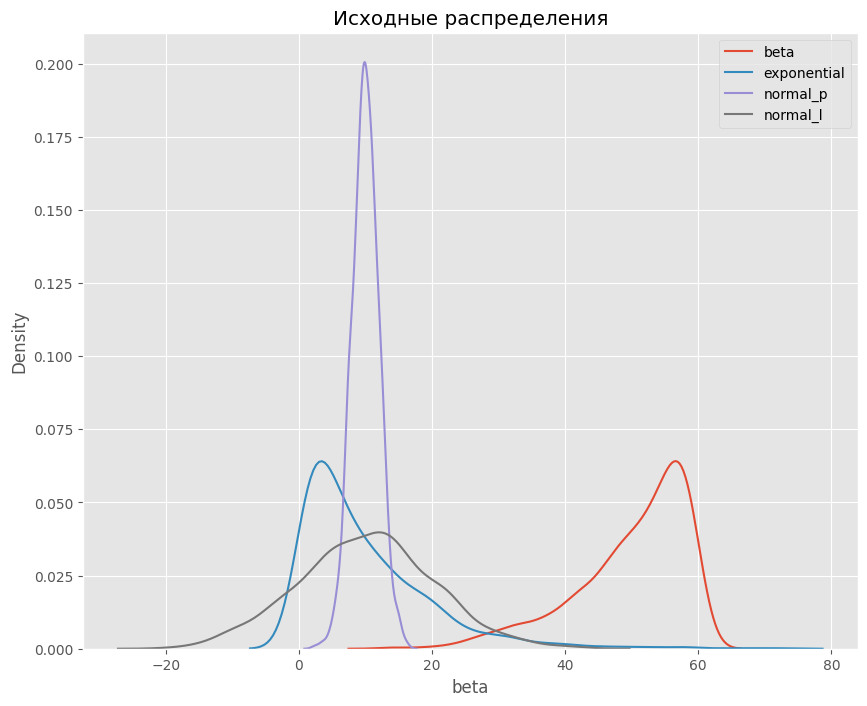

In [267]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Исходные распределения')

# kdeplot() (KDE – оценка плотности ядра) – специальный метод для графиков распределений
sns.kdeplot(df['beta'], ax=ax1, label ='beta')
sns.kdeplot(df['exponential'], ax=ax1, label ='exponential')
sns.kdeplot(df['normal_p'], ax=ax1, label ='normal_p')
sns.kdeplot(df['normal_l'], ax=ax1, label ='normal_l')
plt.legend()

In [268]:
df.describe()

,beta,exponential,normal_p,normal_l
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,50.024249,10.028387,9.994006,10.175745
std,8.474545,9.733928,2.013971,10.104004
min,13.854022,0.007617,2.356844,-19.539980
25%,45.793283,2.951421,8.687478,3.566822
50%,52.337504,7.018565,9.983498,10.326331
75%,56.722191,14.022485,11.306914,16.615057
max,59.990640,71.344341,16.214364,42.072915


Для нормализации данных мы будем использовать уже знакомую нам библиотеку sklearn.

                                   MINMAXSCALER

При применении нормализации методом MinMaxScaler все значения признаков будут преобразованы в диапазон [0,1], что означает, что минимальное и максимальное значение признака будет равно 0 и 1 соответственно.

Проведём нормализацию распределений признаков из обучающего примера.

<AxesSubplot: title={'center': 'После нормализации MinMaxScaler'}, xlabel='beta', ylabel='Density'>

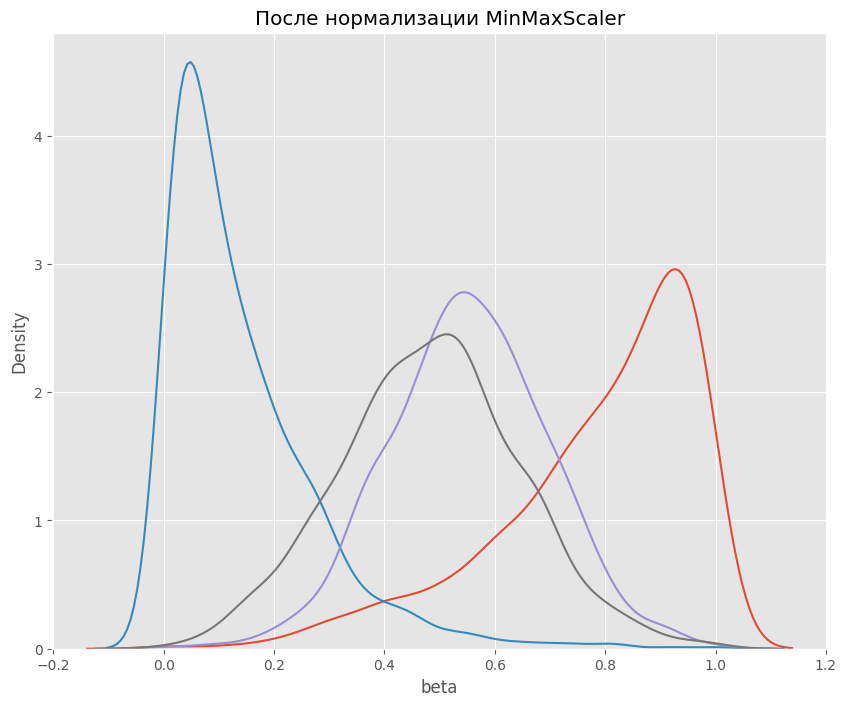

In [269]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
df_mm = mm_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('После нормализации MinMaxScaler')

sns.kdeplot(df_mm['beta'], ax=ax1)
sns.kdeplot(df_mm['exponential'], ax=ax1)
sns.kdeplot(df_mm['normal_p'], ax=ax1)
sns.kdeplot(df_mm['normal_l'], ax=ax1)

Теперь рассмотрим нормализацию методом RobustScaler, а затем сравним их.

<AxesSubplot: title={'center': 'Распределения после RobustScaler'}, xlabel='beta', ylabel='Density'>

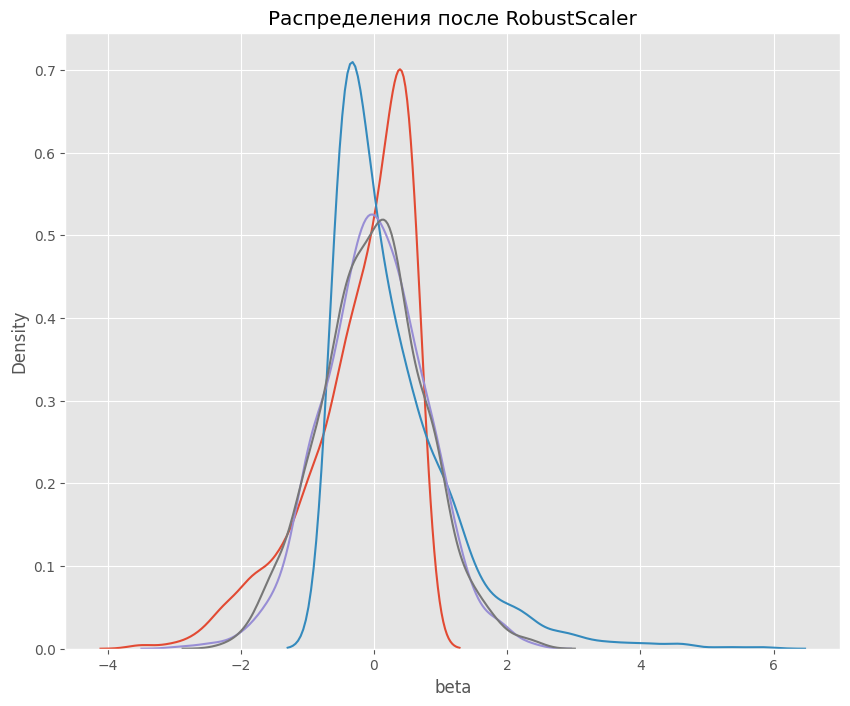

In [270]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
df_r = r_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после RobustScaler')

sns.kdeplot(df_r['beta'], ax=ax1)
sns.kdeplot(df_r['exponential'], ax=ax1)
sns.kdeplot(df_r['normal_p'], ax=ax1)
sns.kdeplot(df_r['normal_l'], ax=ax1)

                                 СТАНДАРТИЗАЦИЯ

Стандартизация — ещё один метод преобразования входных признаков, при котором изменяется распределение таким образом, чтобы среднее значений равнялось 0, а стандартное отклонение — 1. 

Продолжим использовать обучающий пример, сгенерированный нами при изучении нормализации данных. Стандартизируем признаки в исходном наборе данных.

                                   STANDARDSCALER

Для стандартизации используем класс StandardScaler. 

<AxesSubplot: title={'center': 'Распределения после StandardScaler'}, xlabel='beta', ylabel='Density'>

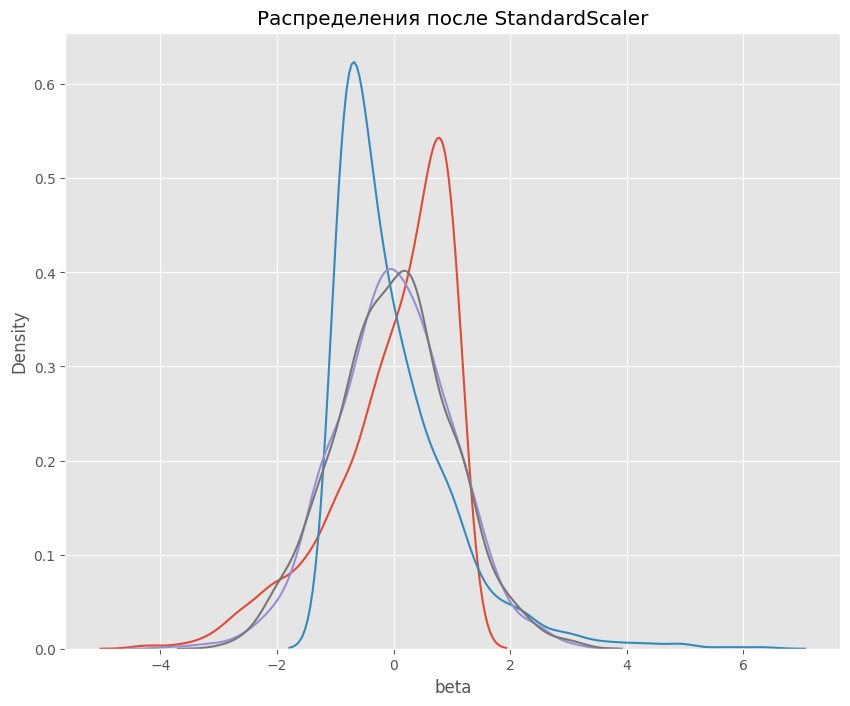

In [271]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# кодируем исходный датасет
df_s = s_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_s = pd.DataFrame(df_s, columns=col_names)

fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
ax1.set_title('Распределения после StandardScaler')

sns.kdeplot(df_s['beta'], ax=ax1)
sns.kdeplot(df_s['exponential'], ax=ax1)
sns.kdeplot(df_s['normal_p'], ax=ax1)
sns.kdeplot(df_s['normal_l'], ax=ax1)

                       НОРМАЛИЗОВАТЬ ИЛИ СТАНДАРТИЗИРОВАТЬ?
если признак распределён нормально, то его необходимо стандартизировать;

если признак распределён ненормально, его необходимо нормализовать;

если разброс значений небольшой, то можно обойтись без преобразования данных.

Нормализуйте признак price. Используйте подходящий тип нормализации.

В ответе напишите результат выполнения кода data['price'].sum(), округлённый до целого.

In [275]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
data['price'] = r_scaler.fit_transform(pd.DataFrame(data['price']))
print(round(data['price'].sum()))

43501


Стандартизируйте исходный признак price.

В ответе напишите результат выполнения кода data['price'][129968]. Ответ округлите до сотых.

In [276]:
# инициализируем стандартизатор StandardScaler
s_scaler = preprocessing.StandardScaler()

# кодируем исходный датасет
data['price_sc'] = s_scaler.fit_transform(data[['price']])
data['price_sc']
data.iloc[129968]['price_sc']

1.001514868120814

In [277]:
data

,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,...,country_2,country_3,country_4,country_5,taster_twitter_handle_0,taster_twitter_handle_1,taster_twitter_handle_2,taster_twitter_handle_3,taster_twitter_handle_4,price_sc
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,0.334700,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),...,0,0,0,1,0,0,0,0,1,0.000003
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,-0.590909,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),...,0,0,1,0,0,0,0,1,0,-0.514525
2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,-0.636364,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),...,0,0,1,1,0,0,0,1,1,-0.539793
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,-0.681818,Michigan,Lake Michigan Shore,Alexander Peartree,unknown,St. Julian 2013 Reserve Late Harvest Riesling ...,...,0,0,1,1,0,0,1,0,0,-0.565060
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,1.681818,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,...,0,0,1,1,0,0,0,1,1,0.748842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129966,Germany,Notes of honeysuckle and cantaloupe sweeten th...,Brauneberger Juffer-Sonnenuhr Spätlese,90,0.000000,Mosel,unknown,Anna Lee C. Iijima,unknown,Dr. H. Thanisch (Erben Müller-Burggraef) 2013 ...,...,0,1,1,0,0,0,1,0,0,-0.186050
129967,US,Citation is given as much as a decade of bottl...,unknown,90,2.136364,Oregon,Oregon,Paul Gregutt,@paulgwine,Citation 2004 Pinot Noir (Oregon),...,0,0,1,1,0,0,0,1,1,1.001515
129968,France,Well-drained gravel soil gives this wine its c...,Kritt,90,0.090909,Alsace,Alsace,Roger Voss,@vossroger,Domaine Gresser 2013 Kritt Gewurztraminer (Als...,...,0,1,0,1,0,0,0,1,0,-0.135515
129969,France,"A dry style of Pinot Gris, this is crisp with ...",unknown,90,0.181818,Alsace,Alsace,Roger Voss,@vossroger,Domaine Marcel Deiss 2012 Pinot Gris (Alsace),...,0,1,0,1,0,0,0,1,0,-0.084981
